In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance

In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 
sheet = pd.read_excel('data_input_auto/煤柴价差日度.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
sheet.index.freq = None
last_day = sheet['华东煤油-山东柴油价差'].last_valid_index()

In [4]:
sheet.head()

,华东煤油-山东柴油价差,中国煤油产量/柴油产量,原油：主营炼厂：加工量：中国（周）,中国主营炼厂产能利用率,山东汽油裂解差,芳烃化工品与烯烃化工品价差,MX（FOB韩国）-石脑油
Date,,,,,,,
2010-11-15,NaN,NaN,NaN,NaN,NaN,NaN,150.875
2010-11-16,NaN,NaN,NaN,NaN,NaN,NaN,159.875
2010-11-17,NaN,NaN,NaN,NaN,NaN,NaN,150.375
2010-11-19,NaN,NaN,NaN,NaN,NaN,NaN,171.875
2010-11-22,NaN,NaN,NaN,NaN,NaN,NaN,164.875


In [5]:
sheet.columns

Index(['华东煤油-山东柴油价差', '中国煤油产量/柴油产量', '原油：主营炼厂：加工量：中国（周）', '中国主营炼厂产能利用率',
       '山东汽油裂解差', '芳烃化工品与烯烃化工品价差', 'MX（FOB韩国）-石脑油'],
      dtype='object')

In [ ]:
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
# 所有数据截止到target_end
sheet = sheet[sheet.index <= target_end]


fill_methods = {
    '中国煤油产量/柴油产量':'interpolate', 
    '原油：主营炼厂：加工量：中国（周）':'interpolate', 
    '中国主营炼厂产能利用率' :'interpolate',
    '山东汽油裂解差':'interpolate', 
    '芳烃化工品与烯烃化工品价差':'interpolate', 
    'MX（FOB韩国）-石脑油':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, '华东煤油-山东柴油价差'] = sheet.loc[:last_day, '华东煤油-山东柴油价差'].interpolate(method='linear')

sheet['中国煤油产量/柴油产量_提前35天'] = sheet['中国煤油产量/柴油产量'].shift(35)
sheet['原油：主营炼厂：加工量：中国（周）_提前35天'] = sheet['原油：主营炼厂：加工量：中国（周）'].shift(35)
sheet['中国主营炼厂产能利用率_提前28天'] = sheet['中国主营炼厂产能利用率'].shift(28)
sheet['山东汽油裂解差_提前42天'] = sheet['山东汽油裂解差'].shift(42)
sheet['芳烃化工品与烯烃化工品价差_提前56天'] = sheet['芳烃化工品与烯烃化工品价差'].shift(56)
sheet['MX（FOB韩国）-石脑油_提前56天'] = sheet['MX（FOB韩国）-石脑油'].shift(56)


sheet['热卷厂内/社会库存比值_提前42天_逆序'] = reverse_column(sheet, '热卷厂内/社会库存比值_提前42天')
sheet['铁矿基差率_提前28天_逆序'] = reverse_column(sheet, '铁矿基差率_提前28天')
sheet['铁矿钢厂库存Trend/F0.1_提前56天_逆序'] = reverse_column(sheet, '铁矿钢厂库存Trend/F0.1_提前56天')

sheet['铁矿基差率_提前28天_逆序_2024-01-01之后'] = np.where(
    sheet.index >= pd.Timestamp('2024-01-01'),
    sheet['铁矿基差率_提前28天_逆序'],
    np.nan
)
################################# 数据筛选  #################################
# 重置索引 确保 `Date` 为 datetime 类型
sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])
# 筛选日期大于 2024-01-01 的行
sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-02-20')]
# 重置索引,使其从0开始 
sheet_daily = sheet_daily.reset_index(drop=True)
# 删除 在 last_day 之前 预测标的 为 空值的 行
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['日均铁水产量'].notna())
]


In [11]:
# 定义函数计算差值并调整预测值
def adjust_future_predictions(y_test, future_data):
    # 计算测试集最后一个值和未来预测第一个值的差
    gap = y_test.iloc[-1] - future_data['预测值'].iloc[0]

    # 创建新列并对所有未来预测值进行调整
    future_data['预测值_移动'] = future_data['预测值'] + gap
    
    return future_data

# 调用函数进行调整
future_data = adjust_future_predictions(y_test, future_data)

# 创建一个新的图形
plt.figure(figsize=(30, 8))


<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

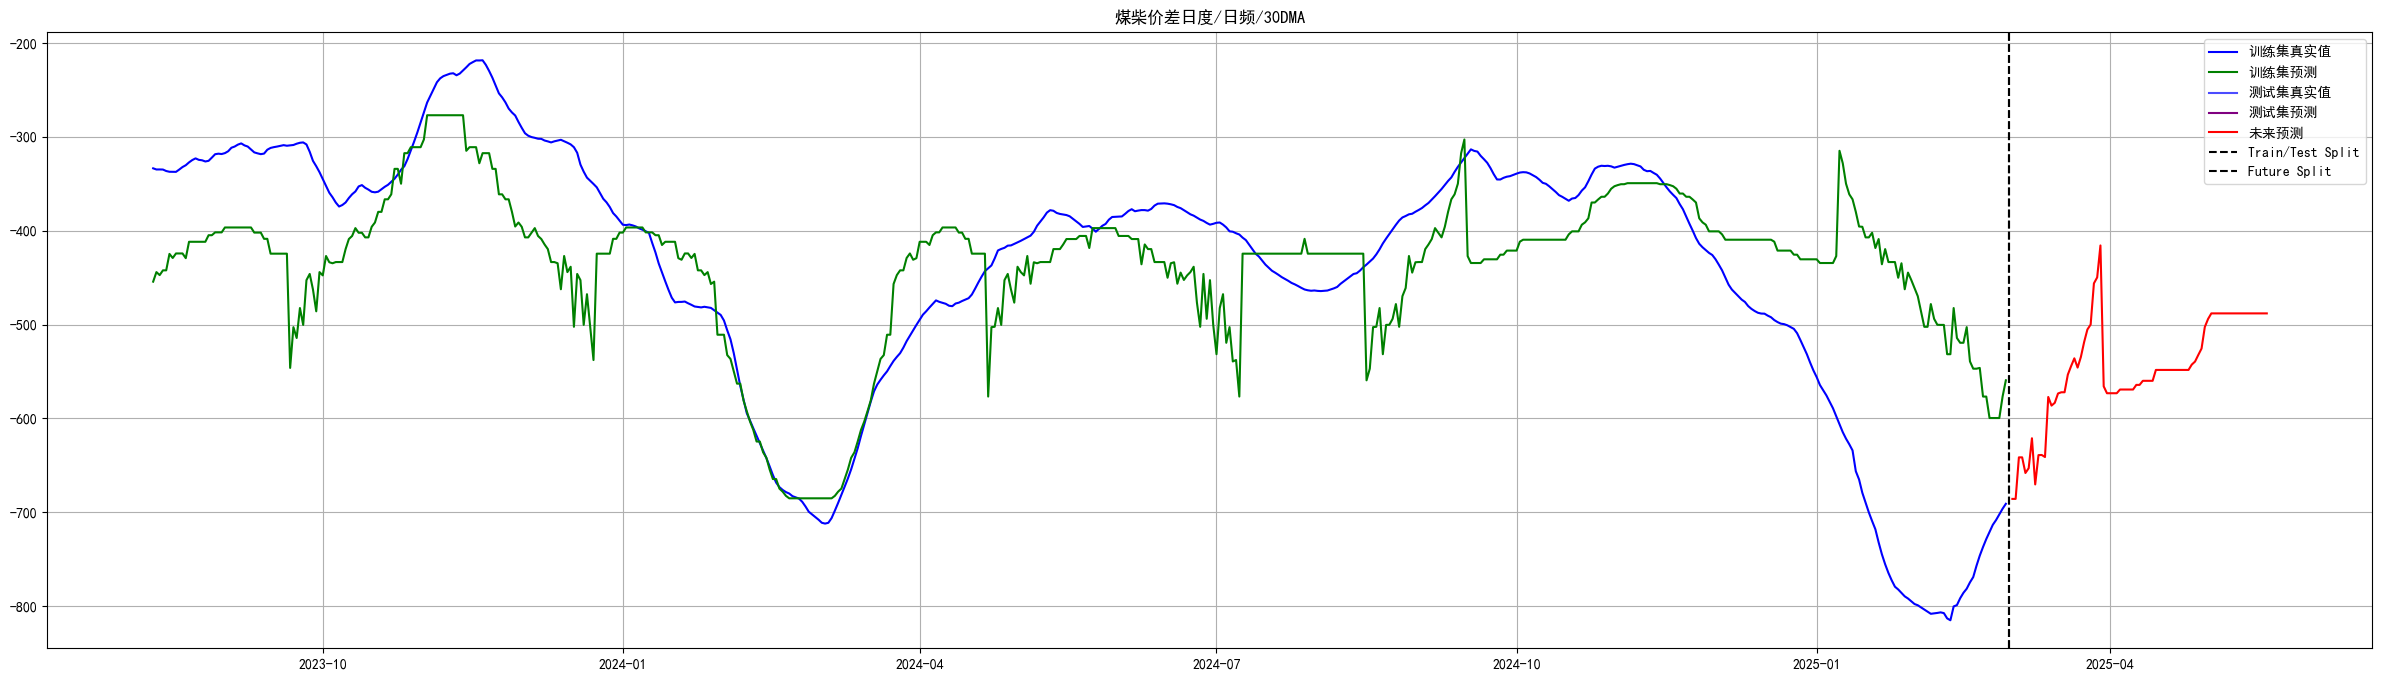

In [12]:
# 可视化
plt.figure(figsize=(30, 8))

plt.plot(train_data['Date'], y_train, label='训练集真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集真实值', color='blue',alpha=0.7)
plt.plot(test_data['Date'], test_data['预测值'], label='测试集预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值_移动'], label='未来预测', color='red')

plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('煤柴价差日度/日频/30DMA')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# 创建一个包含2018年之后数据的DataFrame
train_pred_df = pd.DataFrame({
    'Date': train_data['Date'],
    '预测值': y_train_pred
})
# train_pred_df = train_pred_df[train_pred_df['Date'].dt.year >= 2018]

test_pred_df = pd.DataFrame({
    'Date': test_data['Date'],
    '预测值': test_data['预测值']
})

future_pred_df = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_移动']
})

# 合并所有预测数据
all_predictions = pd.concat([train_pred_df, test_pred_df, future_pred_df])
all_predictions = all_predictions.rename(columns={'预测值': '煤柴价差日度_预测'})

all_predictions

,Date,煤柴价差日度_预测
0,2023-08-10,-454.273956
1,2023-08-11,-444.091766
2,2023-08-12,-447.275726
3,2023-08-13,-442.211334
4,2023-08-14,-442.211334
...,...,...
644,2025-05-15,-488.080200
645,2025-05-16,-488.080200
646,2025-05-17,-488.080200
647,2025-05-18,-488.080200


In [14]:
# 筛选2024年的数据
data_2024 = all_predictions[all_predictions['Date'].dt.year >= 2024].copy()

# 将日期设置为索引
data_2024.set_index('Date', inplace=True)

# 按月重采样并计算平均值
monthly_data = data_2024.resample('ME').mean()

# 重置索引
monthly_data.reset_index(inplace=True)

# 将日期格式化为年月
monthly_data['Date'] = monthly_data['Date'].dt.strftime('%Y-%m-%d')

# 保存到CSV文件
monthly_data.to_csv('data_output_auto/煤柴价差日度_2024月度预测.csv', index=False, encoding='utf-8-sig')
print('数据已保存到: data_output_auto/煤柴价差日度_2024月度预测.csv')

print(monthly_data)

数据已保存到: data_output_auto/煤柴价差日度_2024月度预测.csv
          Date   煤柴价差日度_预测
0   2024-01-31 -423.518372
1   2024-02-29 -633.001831
2   2024-03-31 -573.453003
3   2024-04-30 -432.913147
4   2024-05-31 -417.318359
5   2024-06-30 -438.191925
6   2024-07-31 -448.511505
7   2024-08-31 -458.157379
8   2024-09-30 -407.374084
9   2024-10-31 -395.053955
10  2024-11-30 -360.460754
11  2024-12-31 -415.153046
12  2025-01-31 -413.727936
13  2025-02-28 -532.214661
14  2025-03-31 -576.953186
15  2025-04-30 -553.596802
16  2025-05-31 -488.392670


In [15]:
future_pred_df_rename = future_pred_df.rename(columns={'预测值': '煤柴价差日度_预测'})
future_pred_df_rename.to_csv('data_output_auto/煤柴价差日度_未来日度预测.csv', index=False)
print('未来预测数据已保存到: data_output_auto/山煤柴价差日度_未来日度预测.csv')

future_pred_df_rename

未来预测数据已保存到: data_output_auto/山煤柴价差日度_未来日度预测.csv


,Date,煤柴价差日度_预测
570,2025-03-02,-685.766724
571,2025-03-03,-685.766724
572,2025-03-04,-641.490967
573,2025-03-05,-641.490967
574,2025-03-06,-658.157227
...,...,...
644,2025-05-15,-488.080200
645,2025-05-16,-488.080200
646,2025-05-17,-488.080200
647,2025-05-18,-488.080200


---

In [16]:
# 任务1: 合并训练集、测试集真实值和未来预测
# 获取2023年以后的训练集数据
train_data_2023 = train_data[train_data['Date'].dt.year >= 2023][['Date', '煤柴价差日度/日频/30DMA']]
test_actual = test_data[['Date', '煤柴价差日度/日频/30DMA']]

# 合并训练集和测试集的真实值
historical_actual = pd.concat([train_data_2023, test_actual])
historical_actual.columns = ['Date', '实际值']

# 获取未来预测值
future_pred = future_data[['Date', '预测值_移动']]  # 修改这里的列名
future_pred.columns = ['Date', '预测值']

# 合并所有数据
merged_df = pd.merge(historical_actual, future_pred, on='Date', how='outer')
merged_df = merged_df.sort_values('Date', ascending=False)

# 将日期格式转换为年/月/日格式
merged_df['Date'] = merged_df['Date'].dt.strftime('%Y/%m/%d')

# 保存到Excel
merged_df.to_excel('eta/柴煤价差日度_合并数据.xlsx', index=False,float_format='%.1f')
merged_df

,Date,实际值,预测值
648,2025/05/19,NaN,-488.0802
647,2025/05/18,NaN,-488.0802
646,2025/05/17,NaN,-488.0802
645,2025/05/16,NaN,-488.0802
644,2025/05/15,NaN,-488.0802
...,...,...,...
4,2023/08/14,-336.3667,NaN
3,2023/08/13,-334.8000,NaN
2,2023/08/12,-334.7000,NaN
1,2023/08/11,-334.7333,NaN


In [17]:
# 任务2: 生成月度数据
# 获取2023年以后的实际值
actual_values = pd.concat([
    train_data[train_data['Date'].dt.year >= 2023][['Date', '煤柴价差日度/日频/30DMA']],
    test_data[['Date', '煤柴价差日度/日频/30DMA']]
])
actual_values.columns = ['Date', '实际值']

# 创建包含2024年及以后训练集预测值的DataFrame
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred[train_data['Date'].dt.year >= 2024]
})

# 重新构建predictions DataFrame
predictions = pd.concat([
    train_pred_2024,
    test_data[['Date', '预测值']],
    future_data[['Date', '预测值_移动']]
], ignore_index=True)

# 重新合并实际值和预测值
monthly_df = pd.merge(actual_values, predictions, on='Date', how='outer')

# 转换为月度数据
monthly_df['Date'] = pd.to_datetime(monthly_df['Date'])
monthly_df.set_index('Date', inplace=True)
monthly_df = monthly_df.resample('ME').mean()
monthly_df.reset_index(inplace=True)
monthly_df = monthly_df.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
monthly_df['Date'] = monthly_df['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据
monthly_df.to_excel('eta/柴煤价差日度_月度数据.xlsx', index=False,float_format='%.1f')
monthly_df.head()


,Date,实际值,预测值,预测值_移动
21,2025/05/31,NaN,NaN,-488.392670
20,2025/04/30,NaN,NaN,-553.596802
19,2025/03/31,-685.766700,-546.187317,-577.978699
18,2025/02/28,-770.667864,-532.214661,NaN
17,2025/01/31,-685.445168,-413.727936,NaN
